In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import geopandas as gpd
from shapely.geometry import Polygon
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


c:\Users\angel\anaconda3\envs\mlswiss\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


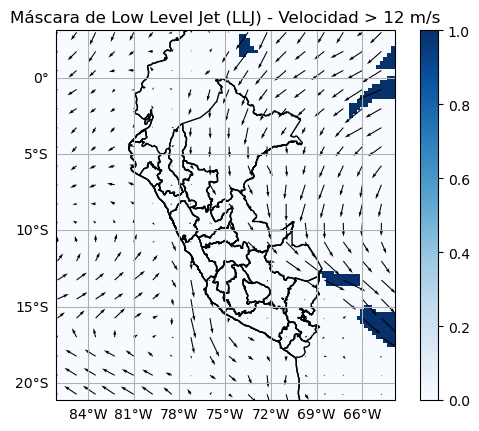

In [51]:
file_path = 'E:/SENAMHI/curso_fita/datos_era5/uv_era5_all.nc'
file_peru = "E:/SENAMHI/QG/departamentos/DEPARTAMENTOS_inei_geogpsperu_suyopomalia.shp"
ds = xr.open_dataset(file_path)

tiempo = 100
u = ds['u'][tiempo, 0, :, :]
v = ds['v'][tiempo, 0, :, :]

lat = ds.latitude.values
lon = ds.longitude.values

x2d, y2d = np.meshgrid(lon, lat)

velocidad_total = np.sqrt(u**2 + v**2)


mask_llj = (velocidad_total > 12) & (lon > -75)

ax = plt.axes(projection=ccrs.PlateCarree())
mask_llj.plot(axes = ax, cmap='Blues', add_colorbar=True)
ax.add_feature(cf.COASTLINE)
ax.add_geometries(Reader(file_peru).geometries(),
                ccrs.PlateCarree(),
                edgecolor='black',
                facecolor = "none")
ax.quiver(x2d[::5,::5], y2d[::5,::5], u[::5,::5], v[::5,::5], transform=ccrs.PlateCarree())
plt.title("Máscara de Low Level Jet (LLJ) - Velocidad > 12 m/s")
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()


In [ ]:

def mask_to_geometries(mask, latitudes, longitudes):

    labeled, num_labels = label(mask, return_num=True)
    geometries = []
    
    if mask.shape != (latitudes.size, longitudes.size):
        raise ValueError("La forma de la máscara no coincide con las coordenadas de latitudes/longitudes")

    for region in regionprops(labeled):
        minr, minc, maxr, maxc = region.bbox
        
        lat_min = latitudes[minr] if minr >= 0 else latitudes[0]
        lat_max = latitudes[maxr] if maxr < len(latitudes) else latitudes[-1]
        lon_min = longitudes[minc] if minc >= 0 else longitudes[0]
        lon_max = longitudes[maxc] if maxc < len(longitudes) else longitudes[-1]

        polygon = Polygon([
            (lon_min, lat_min),
            (lon_min, lat_max),
            (lon_max, lat_max),
            (lon_max, lat_min),
        ])
        
        geometries.append(polygon)
    
    return geometries

In [52]:
geometries_observacion = mask_to_geometries(mask_llj, lat, lon)

In [53]:
gdf_observacion = gpd.GeoDataFrame(geometry=geometries_observacion, crs="EPSG:4326")

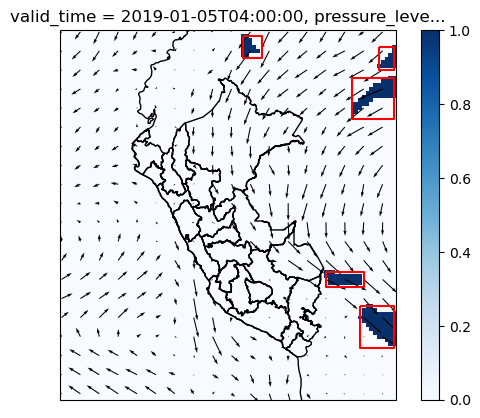

In [54]:

ax = plt.axes(projection=ccrs.PlateCarree())
mask_llj.plot(axes = ax, cmap='Blues', add_colorbar=True)
gdf_observacion.boundary.plot(ax = ax, color = "red")
ax.add_feature(cf.COASTLINE)
ax.add_geometries(Reader(file_peru).geometries(),
                ccrs.PlateCarree(),
                edgecolor='black',
                facecolor = "none")
ax.quiver(x2d[::5,::5], y2d[::5,::5], u[::5,::5], v[::5,::5], transform=ccrs.PlateCarree())

In [23]:
from skimage.measure import find_contours
from shapely.geometry import Polygon

In [39]:
import skimage
skimage.__version__

'0.24.0'

In [32]:
type(mask_llj.values)

numpy.ndarray

In [ ]:

def mask_to_geometries_contour(mask, latitudes, longitudes):

    mask = mask.values

    if isinstance(mask, np.ndarray):
        mask_array = mask
    elif isinstance(mask, xr.DataArray): 
        mask_array = mask.values 
    else:
        raise TypeError("El tipo de mask no es compatible. Debe ser un numpy.ndarray o xarray.DataArray.")
    

    print(f"Tipo de datos de mask_array: {type(mask_array)}")
    print(f"Forma de mask_array: {mask_array.shape}")

    contours = find_contours(mask, level=0.5)  
    
    geometries = []
    
    for contour in contours:
        contour_coords = [(longitudes[int(x)], latitudes[int(y)]) for y, x in contour]
        
        polygon = Polygon(contour_coords)
        
        if polygon.is_valid:
            geometries.append(polygon)
    
    return geometries

In [55]:
geometries_observacion2 = mask_to_geometries_contour(mask_llj, lat, lon)
gdf_observacion2 = gpd.GeoDataFrame(geometry=geometries_observacion2, crs="EPSG:4326")

Tipo de datos de mask_array: <class 'numpy.ndarray'>
Forma de mask_array: (97, 89)


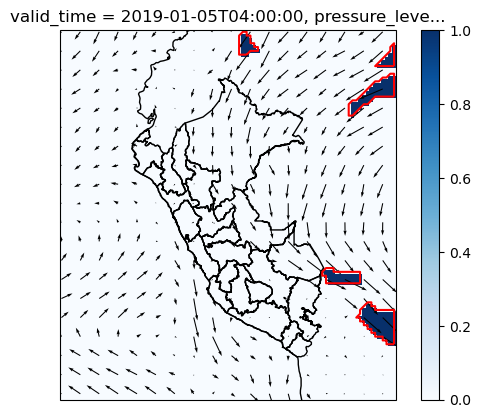

In [56]:

ax = plt.axes(projection=ccrs.PlateCarree())
mask_llj.plot(axes = ax, cmap='Blues', add_colorbar=True)
gdf_observacion2.boundary.plot(ax = ax, color = "red")
ax.add_feature(cf.COASTLINE)
ax.add_geometries(Reader(file_peru).geometries(),
                ccrs.PlateCarree(),
                edgecolor='black',
                facecolor = "none")
ax.quiver(x2d[::5,::5], y2d[::5,::5], u[::5,::5], v[::5,::5], transform=ccrs.PlateCarree())